In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#Lista de pixels a serem removidos após cada passo da iteracao
pixelsASeremRemovidos = []



'''
Para cada pixel P1 examinado, seus vizinhos serao analisados da seguinte forma:
P9 P2 P3
P8 P1 P4
P7 P6 P5
'''

#Calculo para ver se pelo menos um dos pixels P2, P4 e P6 eh 0
def p2p4p6(img, posicao):    
    return img[posicao[0]][posicao[1]-1]*img[posicao[0]+1][posicao[1]]*img[posicao[0]][posicao[1]+1]

#Calculo para ver se pelo menos um dos pixels P4, P6 e P8 eh 0    
def p4p6p8(img, posicao):
    return img[posicao[0]+1][posicao[1]]*img[posicao[0]][posicao[1]+1]*img[posicao[0]-1][posicao[1]]

#Calculo para ver se pelo menos um dos pixels P2, P4 e P8 eh 0    
def p2p4p8(img, posicao):
    return img[posicao[0]][posicao[1]-1]*img[posicao[0]+1][posicao[1]]*img[posicao[0]-1][posicao[1]]
    
#Calculo para ver se pelo menos um dos pixels P2, P6 e P8 eh 0
def p2p6p8(img, posicao):
    return img[posicao[0]][posicao[1]-1]*img[posicao[0]][posicao[1]+1]*img[posicao[0]-1][posicao[1]]
  
#Calcula quantos vizinhos do pixel P1 sao diferentes de 0    
def vizinhancaPixelsNaoNulos(img, posicao):
    pixelsNaoNulos = 0
   
    #Comeca na linha logo acima (-1) de P1 e acaba na linha logo abaixo (+1)
    for i in range(-1,2):
        #Comeca na coluna a esquerda (-1) de P1 e acaba na coluna a direita (+1)
        for j in range(-1,2):
            #Desconsidera o próprio P1
            if not(i == 0 and j == 0):
                if img[posicao[0] + i][posicao[1] + j] != 0:
                    pixelsNaoNulos += 1
    
    return pixelsNaoNulos

#Calcula quantas transicoes de 0 para 1 temos na vizinhanca de P1
def transicaoVizinhanca(img, posicao):
    transicao = 0
    
    '''A sequencia de verificacao eh:
        P2->P3, P3->P4, P4->P5, P5->P6, P6->P7, P7->P8, P8->P9, P9->P2
    '''
    #Adiciona os pixels em ordem para a verificacao, note que P2 esta em primeiro e por ultimo na lista
            #(poderia apenas estar em ultimo e acessar pelo indice -1 da lista?)
    sequenciaPixels = [img[posicao[0]-1][posicao[1]],img[posicao[0]-1][posicao[1]+1],img[posicao[0]][posicao[1]+1],
                       img[posicao[0]+1][posicao[1]+1],img[posicao[0]+1][posicao[1]],img[posicao[0]+1][posicao[1]-1],
                       img[posicao[0]][posicao[1]-1],img[posicao[0]-1][posicao[1]-1],img[posicao[0]-1][posicao[1]]]
    
    #Verifica se ha a transicao e conta quantas transicoes ha
    pixelAnterior = sequenciaPixels[0]
    for i in range(1,9):
        if sequenciaPixels[i] != 0 and pixelAnterior == 0:
            transicao += 1
        pixelAnterior = sequenciaPixels[i]
            
    return transicao

#Remove todos os pixels da lista de remocao
def removePixels(img):
    img_temp = img.copy()
    while pixelsASeremRemovidos:
        posicao = pixelsASeremRemovidos.pop(0)
        img_temp[posicao[0]][posicao[1]] = 0
    
    return img_temp

#Algoritmo Zhan-Suen de esqueletonizacao
'''
A ideia desse algoritmo eh verificar todos os pixels da imagem usando dois passos de verificacoes, alem de ter 8 vizinhos:
1)Remova o pixel (adicione na lista de remocao) se o pixel obedecer a todas as condicoes:
    a)O pixel tiver valor 1;
    b)O numero de vizinhos nao nulos for maior ou igual que 2 e menor ou igual que 6;
    c)Se o numero de transicoes de 0 para 1 for exatamente 1;
    d)Se houver pelo menos um pixel nulo entre P2, P4, P6;
    e)Se houver pelo menos um pixel nulo entre P4, P6, P8;
Apos passar todos os pixels pelo passo 1, remova-os(mude para 0).

2)Remova o pixel (adicione na lista de remocao) se o pixel obedecer a todas as condicoes, alem de ter 8 vizinhos:
    a)O pixel tiver valor 1;
    b)O numero de vizinhos nao nulos for maior ou igual que 2 e menor ou igual que 6;
    c)Se o numero de transicoes de 0 para 1 for exatamente 1;
    d)Se houver pelo menos um pixel nulo entre P2, P4, P8;
    e)Se houver pelo menos um pixel nulo entre P2, P6, P8;
Apos passar todos os pixels pelo passo 1, remova-os(mude para 0).

Repita esse processo ate que nenhum pixel seja modificado.
'''
def esqueletonizacao(img):
    mudou = True
    esqueleto_img = img
    
    while mudou:
        mudou = False
        #Passo 1, pega todos os pixels menos os das bordas
        for row in range(1, esqueleto_img.shape[0]-1):
            for col in range(1, esqueleto_img.shape[1]-1):
                
                posicao = [row,col]
                #a)
                if esqueleto_img[row][col]:
                    #b)
                    if (vizinhancaPixelsNaoNulos(esqueleto_img, posicao) >=2 
                        and vizinhancaPixelsNaoNulos(esqueleto_img, posicao) <= 6):
                        #c)
                        if transicaoVizinhanca(esqueleto_img, posicao) == 1: 
                            #d)
                            if p2p4p6(esqueleto_img, posicao) == 0:
                                #e)
                                if p4p6p8(esqueleto_img, posicao) == 0:
                                    pixelsASeremRemovidos.append(posicao)
                                    mudou = True
                                    
        #Remova todos os pixels da lista
        esqueleto_img = removePixels(esqueleto_img)
        
        #Passo2, pega todos os pixels menos os das bordas
        for row in range(1, esqueleto_img.shape[0]-1):
            for col in range(1, esqueleto_img.shape[1]-1):
                posicao = [row,col]
                #a)
                if esqueleto_img[row][col]:
                    #b)
                    if (vizinhancaPixelsNaoNulos(esqueleto_img, posicao) >=2 
                        and vizinhancaPixelsNaoNulos(esqueleto_img, posicao) <= 6):
                        #c)
                        if transicaoVizinhanca(esqueleto_img, posicao) == 1: 
                            #d)
                            if p2p4p8(esqueleto_img, posicao) == 0:
                                #e)
                                if p2p6p8(esqueleto_img, posicao) == 0:
                                    pixelsASeremRemovidos.append(posicao)
                                    mudou = True
                                    
        #Remova todos os pixels da lista                       
        esqueleto_img = removePixels(esqueleto_img)
                
    return esqueleto_img
                                
                                
         



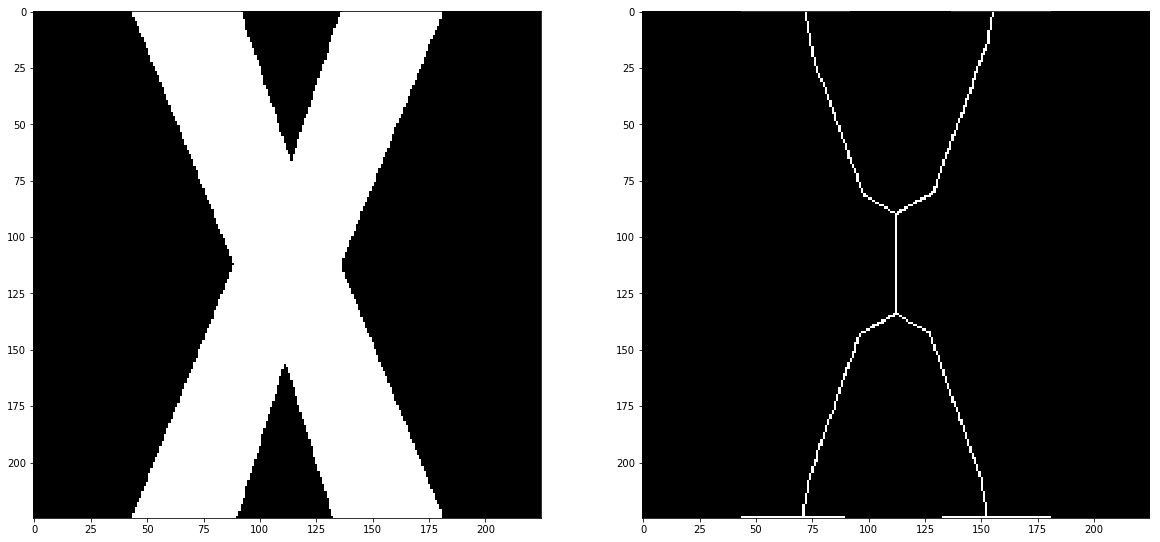

In [3]:
#Imagem de um X retirada da internet
test = cv2.imread('x.png' , 0)
#Binarizacao da imagem
test = test>25
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(test, 'gray')
esqueleto_img = esqueletonizacao(test)
plt.subplot(1,2,2)
plt.imshow(esqueleto_img, 'gray')

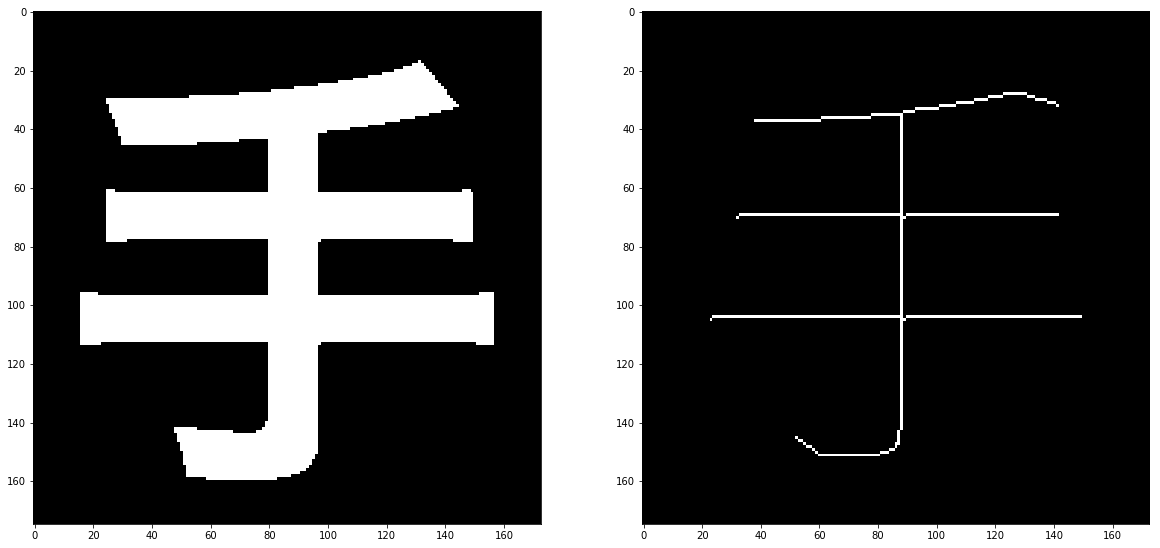

In [4]:
#Imagem retirada de https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm
test = cv2.imread('test1.bmp' , 0)
#Binarizacao da imagem
test = test<220
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(test, 'gray')
esqueleto_img = esqueletonizacao(test)
plt.subplot(1,2,2)
plt.imshow(esqueleto_img, 'gray')

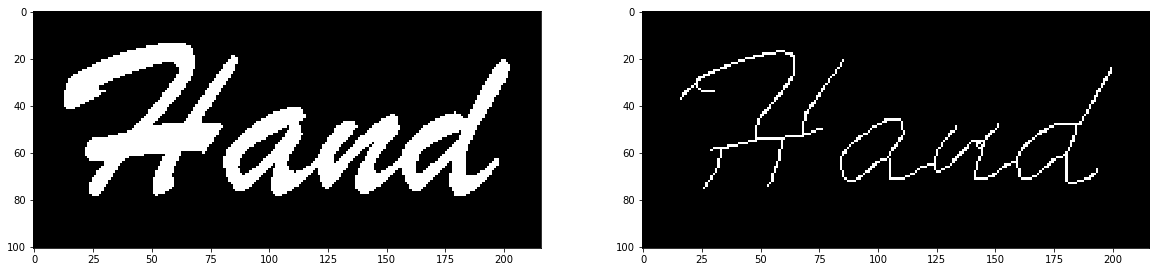

In [5]:
#Imagem retirada de https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm
test = cv2.imread('test2.bmp' , 0)
#Binarizacao da imagem
test = test<220
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(test, 'gray')
esqueleto_img = esqueletonizacao(test)
plt.subplot(1,2,2)
plt.imshow(esqueleto_img, 'gray')

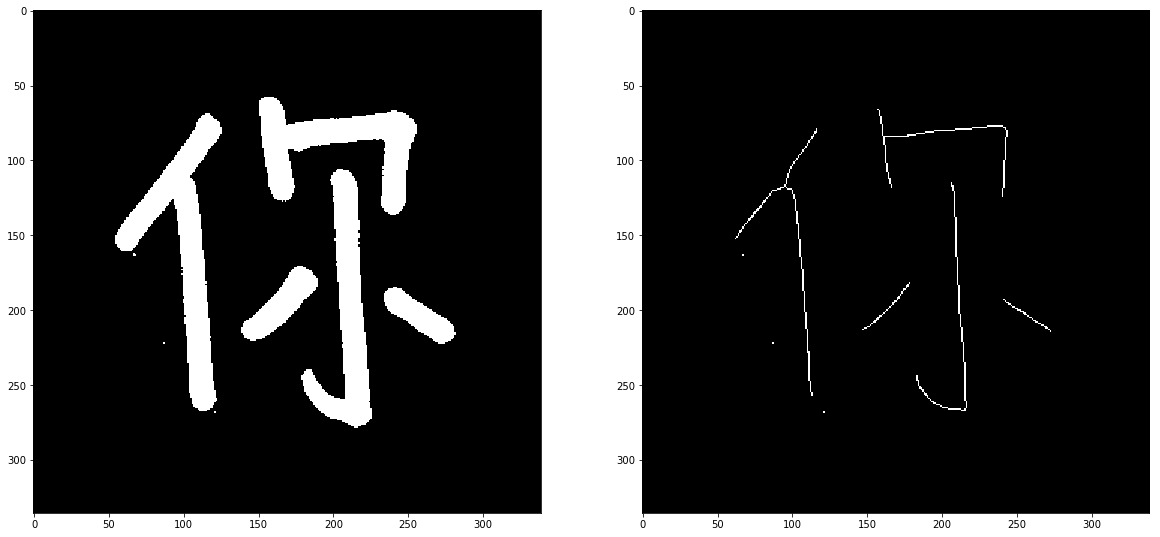

In [6]:
#Imagem retirada de https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm
test = cv2.imread('test3.bmp' , 0)
#Binarizacao da imagem
test = test<220
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(test, 'gray')
esqueleto_img = esqueletonizacao(test)
plt.subplot(1,2,2)
plt.imshow(esqueleto_img, 'gray')

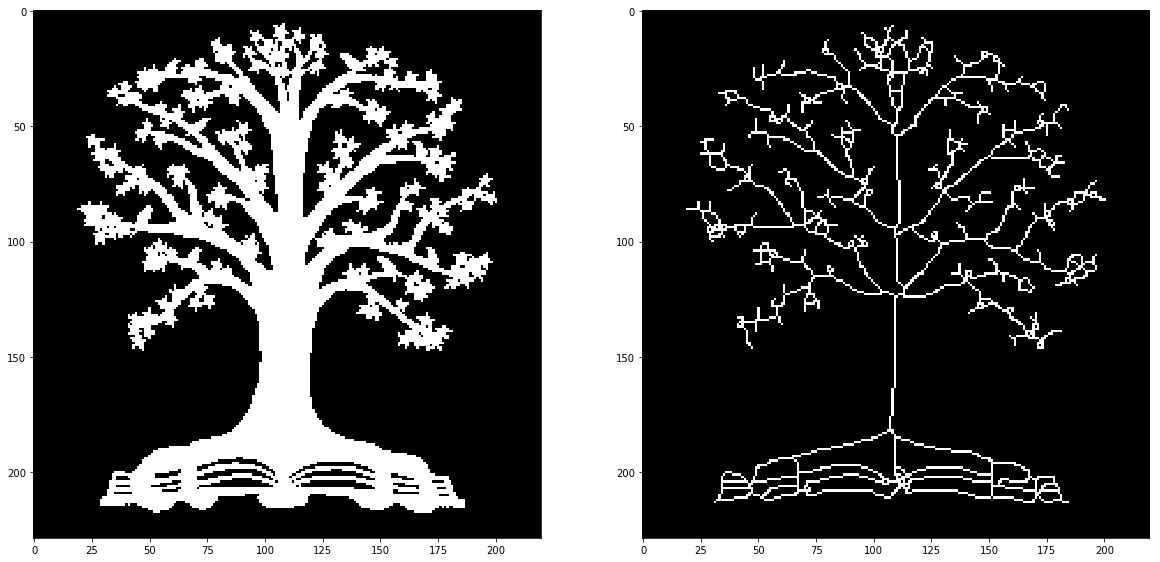

In [7]:
#Imagem retirada de https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm
test = cv2.imread('test4.bmp' , 0)
#Binarizacao da imagem
test = test<220
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(test, 'gray')
esqueleto_img = esqueletonizacao(test)
plt.subplot(1,2,2)
plt.imshow(esqueleto_img, 'gray')